In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler, MaxAbsScaler,  LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline


from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout


import matplotlib.pyplot as plt

from ipywidgets import interact
import ipywidgets as widgets

%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_poke_xy(dummies = True, label_encode = False, scaler = None, test_size = 0.3, random_state = 777, n_folds = 5):
    df = pd.read_csv("pokemon.zip", index_col = "Name")

    cat_cols = ["Type 1", "Type 2", "Generation"]
    num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
    target_col = "Legendary"
    drop_cols = ["#"]
    y_all = df[target_col].astype("int")
    
    X_all = df.drop(target_col , axis = 1)
    X_all.drop(drop_cols,axis=1, inplace = True)
    
    if label_encode:
        for c in cat_cols:
            try:
                X_all[c] = LabelEncoder().fit_transform(X_all[c].fillna("NaN"))
            except TypeError:
                print("could not encode: ", c)
    if dummies:
        X_all = X_all.drop(cat_cols, axis=1).join(pd.get_dummies(X_all[cat_cols].astype("category")))
    
    
    if scaler:
        sc = scaler()
        X_all[num_cols]  = sc.fit_transform(X_all[num_cols])
    
    kf = StratifiedKFold(n_splits = n_folds )
    folds = list(kf.split(X_all, y_all))
    
    return X_all, y_all, folds 

In [3]:
def train_model(X, y, folds, model = LogisticRegression, 
                model_params = {"penalty" :"l1", "solver" :"liblinear"}, 
                fit_params = None):
    
    colors = ["r","g", "b", "y", "c"]
    oof_preds = np.zeros(X.shape[0])
    scores = []
    models = []

    plt.subplots(figsize = (10, 10))
    #print(tgt, ":")
    plt.subplot(1, 1, 1)
    for i, (i_tr, i_te) in enumerate(folds):
        
        Xtr, Xte = X.iloc[i_tr], X.iloc[i_te]
        ytr, yte = y.iloc[i_tr], y.iloc[i_te]
        
        if model_params:
            mdl = model(**model_params)
        else: mdl = model()

        if fit_params:
            mdl.fit(Xtr, ytr, **fit_params)
        else:
            mdl.fit(Xtr, ytr)
    
        models.append(mdl)
        preds =  mdl.predict_proba(Xte)[:, 1]
        oof_preds[i_te] = preds
        score = roc_auc_score(yte, preds)
        scores.append(score)
        fpr, tpr, threshold = roc_curve(yte, preds)
        plt.plot(fpr, tpr, color = colors[i] , label = f"fold:{i}, AUC:{score:.3f}")
        
    plt.title(f"{model.__name__} AUC:{np.mean(scores):.3f}")
    plt.legend(loc=4)
    plt.show()
    return oof_preds, scores, models

In [4]:
def train_nn(X, y, folds,  n_epochs = 20, batch_size = 32, seed = 777):
    colors = ["r","g", "b", "y", "c"]
    oof_preds = np.zeros(X.shape[0])
    scores = []
    models = []
    plt.subplots(figsize = (10, 10))
    #print(tgt, ":")
    plt.subplot(1, 1, 1)
    for i, (i_tr, i_te) in enumerate(folds):
        Xtr, Xte = X.iloc[i_tr], X.iloc[i_te]
        ytr, yte = y.iloc[i_tr], y.iloc[i_te]

        model = Sequential()
        model.add(Dense(64, input_dim=Xtr.shape[1], activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
    
            # For a binary classification problem
        model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        model.fit(Xtr, ytr, epochs = n_epochs, batch_size = batch_size, verbose = 0)

        preds = model.predict_proba(Xte)[:, 0]
        score = roc_auc_score(yte, preds)
        oof_preds[i_te] = preds
        scores.append(score)
        models.append(model)
        fpr, tpr, threshold = roc_curve(yte, preds)
        plt.plot(fpr, tpr, color = colors[i] , label = f"fold:{i}, AUC:{score:.3f}")
        
    plt.title(f"MLP AUC:{np.mean(scores):.3f}")
    plt.legend(loc=4)
    plt.show()
    return oof_preds, scores, models

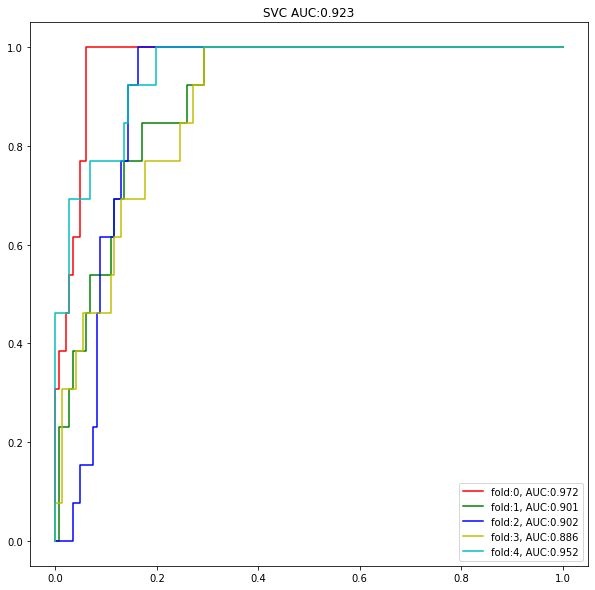

In [5]:
X_all, y_all, folds  = get_poke_xy(scaler = StandardScaler)
svm_preds, svm_scores, svm_models = train_model(X_all, y_all, folds, model = SVC, 
                                         model_params = {"kernel":"linear" ,
                                                         "probability" : True, "gamma":"auto"})

WARNING - From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
WARNING - From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
WARNING - From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



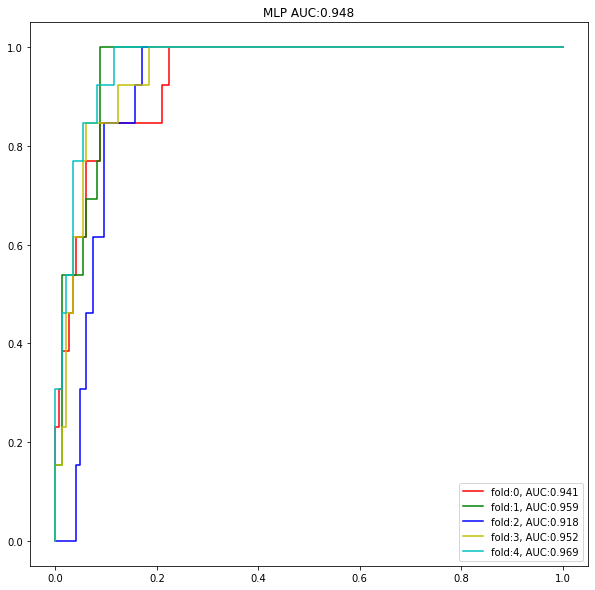

In [6]:
nn_preds, nn_scores, nn_models = train_nn(X_all, y_all, folds, n_epochs = 16, batch_size = 10)

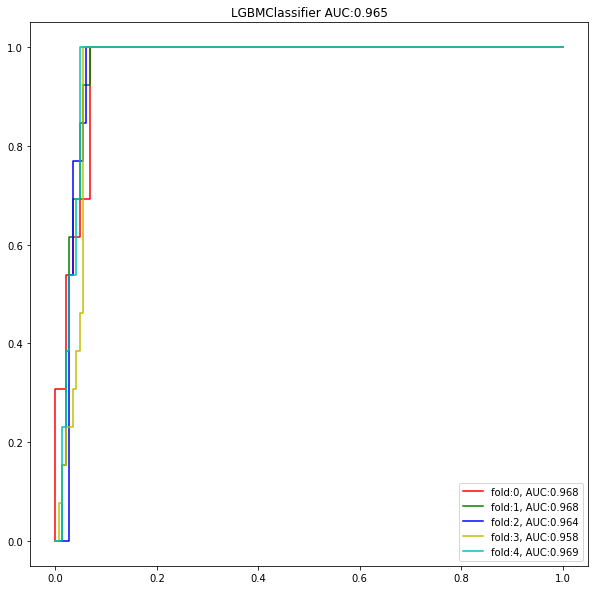

In [7]:
X_all_lab, y_all_lab, folds  = get_poke_xy(dummies = False, label_encode=True)

lgb_preds, lgb_scores, lgb_models = train_model(X_all_lab, y_all_lab, folds, model = lgb.LGBMClassifier, 
                                         model_params = {"n_estimators" : 500,
                                                         "learning_rate" : 0.01})

In [8]:
import shap
shap.initjs()

In [9]:
def display_svm_summary(fold):
    X_train = X_all.iloc[folds[fold][0]]
    X_test = X_all.iloc[folds[fold][1]]
    f = lambda x: svm_models[fold].predict_proba(x)[:, 1]
    med = X_train.median().values.reshape((1,X_train.shape[1]))
    
    expl = shap.KernelExplainer(f, med )
    shap_vals = expl.shap_values(X_test)
    shap.summary_plot(shap_vals, X_test)

In [10]:
import warnings

In [11]:
warnings.filterwarnings("ignore")

In [12]:
interact(display_svm_summary,
         fold = widgets.IntText(min=0,max = 4, value=0))

interactive(children=(IntText(value=0, description='fold'), Output()), _dom_classes=('widget-interact',))

<function __main__.display_svm_summary(fold)>

In [13]:
fold  = 0
X_train = X_all.iloc[folds[fold][0]]
X_test = X_all.iloc[folds[fold][1]]
f = lambda x: svm_models[fold].predict_proba(x)[:, 1]
med = X_train.median().values.reshape((1,X_train.shape[1]))
    
expl = shap.KernelExplainer(f, med )
shap_vals = expl.shap_values(X_test)

In [14]:
def display_svm_single(i):
    shap_values_single = expl.shap_values(X_test.iloc[i,:], nsamples=1000)
    return shap.force_plot(float(expl.expected_value), shap_values_single, 
                    X_test.iloc[i,:].values, feature_names = X_test.columns)

In [15]:
interact(display_svm_single,
         i = widgets.IntText(min=0,max = X_test.shape[1], value=0))

interactive(children=(IntText(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.display_svm_single(i)>

In [16]:
shap_values = expl.shap_values(X_test.iloc[0:100,:], nsamples=1000)
shap.force_plot(float(expl.expected_value), 
                shap_values, X_test.iloc[0:100,:].values, feature_names = X_test.columns)

In [18]:
fold  = 0
X_train = X_all.iloc[folds[fold][0]]
X_test = X_all.iloc[folds[fold][1]]
f = lambda x: nn_models[fold].predict(x)
med = X_train.median().values.reshape((1,X_train.shape[1]))
    
expl = shap.KernelExplainer(f, med )
shap_vals = expl.shap_values(X_test)

In [19]:
def display_single(i):
    shap_values_single = expl.shap_values(X_test.iloc[i,:], nsamples=1000)
    return shap.force_plot(float(expl.expected_value), shap_values_single[0], 
                    X_test.iloc[i,:].values, feature_names = X_test.columns)

In [20]:
interact(display_single,
         i = widgets.IntText(min=0,max = X_test.shape[1], value=0))

interactive(children=(IntText(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.display_single(i)>

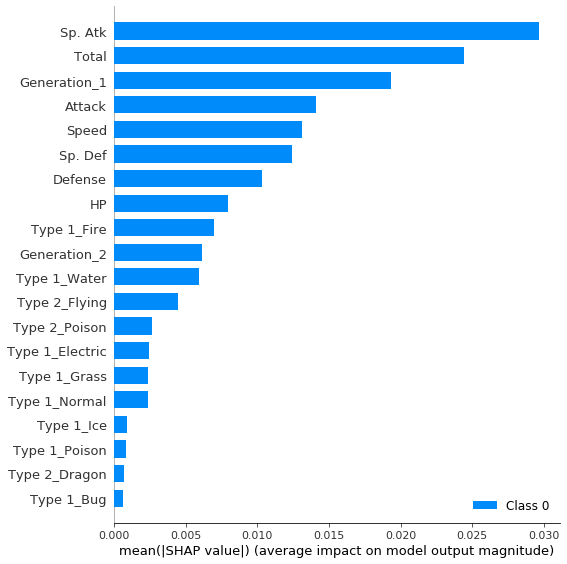

In [21]:
shap_vals = expl.shap_values(X_test)
shap.summary_plot(shap_vals, X_test)

In [39]:
def display_lgb_summary(fold):
    Xtr = X_all_lab
    expl = shap.TreeExplainer(lgb_models[fold])
    shap_vals = expl.shap_values(Xtr)
    return shap.summary_plot(shap_vals, Xtr)

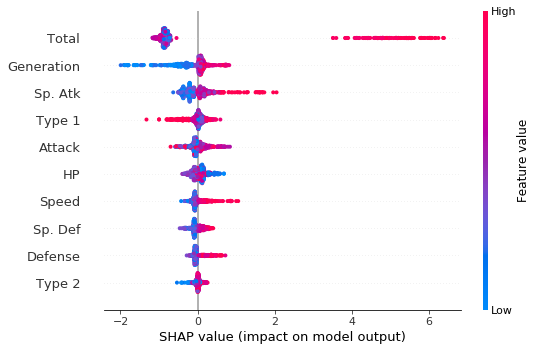

In [40]:
display_lgb_summary(0)

In [41]:
def display_single(fold,  i):
    X_test = X_all.iloc[folds[fold][1]]
    shap_values_single = expl.shap_values(X_test.iloc[i,:], nsamples=1000)
    return shap.force_plot(float(expl.expected_value), shap_values_single[0], 
                    X_test.iloc[i,:].values, feature_names = X_test.columns)

In [45]:
interact(display_single,
         fold = widgets.IntText(min=0,max = 4, value=0),
         i = widgets.IntText(min=0,max = X_test.shape[1], value=0))

interactive(children=(IntText(value=0, description='fold'), IntText(value=0, description='i'), Output()), _dom…

<function __main__.display_single(fold, i)>